# Pipeline
- 여러 단계(전처리, 변환, 추정)를 연속적으로 연결하여 실행하는 도구
- 전처리와 모델을 하나의 객체로 결합해서 사용이 가능
- 교차검증, 하이퍼 파라미터 탐색에서 유용 사용
- 데이터의 누수를 방지 : fit_transform()이 학습데이터에만 적용이 되도록 자동 관리

- 매개변수
    - steps
        - 필수 항목 (dict 형태의 데이터 타입)
        - 파이프라인의 단계들을 커스텀한 이름과 객체들을 쌍으로 묶어서 dict 형태로 구성
        - 예. [ ( 'scaler', StandardScaler()), ( 'svc', SVC() ) ]
    - verbose
        - 기본값: False
        - 각 단계가 실행이 될 때 로그를 출력할 것인가?
- 속성
    - named_steps
        - 파이프라인의 각 단계를 딕셔너리형처럼 접근이 가능
        - 예. pipe.named_steps['svc']

- 메서드
    - fit(x, y, fit_params)
        - 순서대로 각 단계의 fit을 진행
        - 마지막 단계는 예측이 가능한 모델이어야한다.
    - fit_transform(x, y, fit_params)
        - 순서대로 각 단계의 fit_transform()을 진행
        - 마지막 단계가 변환을 시켜주는 클래스
    - predict(x)
        - 마지막 단계에서 predict 함수를 호출

In [90]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris

In [91]:
# 데이터 로드
iris = pd.read_csv("../data_git/data/iris.csv")

In [92]:
iris['target'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [93]:
for i, key in enumerate(iris['target'].unique()):
    print(i)
    print(key)
    iris['target'] = iris['target'].replace(key, i)

0
Iris-setosa
1
Iris-versicolor
2
Iris-virginica


/var/folders/v0/r6b3g15j6gd1x8947g8ly2qr0000gn/T/ipykernel_74192/2998124518.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  iris['target'] = iris['target'].replace(key, i)


In [94]:
iris['target'].value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [95]:
x = iris.drop('target', axis=1)
y = iris['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [96]:
# 파이프라인을 생성 -> StdScaler를 이용, SVC() 모델을 사용
pipe = Pipeline(
    [
        ('Scaler', StandardScaler()),
        ('svc', SVC()),
    ],
    verbose = True
)

In [97]:
pipe.fit(X_train, Y_train)

[Pipeline] ............ (step 1 of 2) Processing Scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svc, total=   0.0s


,steps,"[('Scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,True
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [98]:
pred_pipe = pipe.predict(X_test)

In [99]:
# 분류 보고서 출력
print(classification_report(pred_pipe, Y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.88      0.90        16
           2       0.87      0.93      0.90        14

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



# GridSearchCV
- 하이퍼파라미터(매개변수) 조합을 탐색하여 최적의 조합을 찾는 방법
- 각 파라미터 조합별로 교차검증(CV)을 수행해 평균 성능 비교
- 최적의 모델과 성능을 자동으로 제공

- 매개변수
    - estimator
        - 모델의 선택
        - 예. SVC()
    -param_grid
        - 탐색할 파라미터의 조합
        - 예. {'C' : [0, 1, 10], 'kernel' : ['linear', 'rbf']}
    - cv
        - 교차 검증의 횟수
        - 5 -> 5-폴드 교차 검증
    - scoring
        - 기본값 : None
        - 평가 지표 설정
        - 기존에 제공하는 평가 지표와 커스텀하여 생성한 평가 지표도 사용 가능
    - refit
        - 기본값: True
        - 최적의 파라미터로 전체 데이터를 다시 학습할 것인가
        - True인 경우에는 속성 중 best_estimator_ 사용 가능
    - error_score
        - 기본값: np.nan
        - 모델 학습 시 오류가 발생했을 때 어떤 방식으로 처리할 것인가?
        - "raise" -> 에러 발생/숫자 -> 해당 스코어를 발생하는 숫자로 표시
    - return_train_score
        - 기본값: False
        - 교차검증 시 훈련 성능 점수까지 반영을 할 것인가?
    - verbose
        - 기본값 : 0
        - 출력 로그의 수준 (0: 없음, 1: 간단하게 표시, 2: 상세하게 표시)
    - n_jobs
        - 기본값: None
        - cpu 병렬 처리 개수
        - -1 : 모든 코어를 사용
- 속성
    - cv_results
        - 각 파라미터 조합 별 성능 결과 (훈련/검증 점수, fit 시간)
    - best_estimator_
        - 최적의 파라미터로 다시 학습이 된 모델 객체
    - best_params_
        - 최적의 성능을 낸 파라미터 조합
    - best_score_
        - 최적의 파라미터 조합을 이용한 교차 검증에서의 평균 성능 점수
    - refit_time_
        - 최적의 파라미터로 refit을 하는데 걸린 시간
- 메서드
    - fit(x, y)
        - 모든 파라미터 조합에 대해 학습하고 평가 -> 최적의 모델을 학습
    - predict(x)
        - 최적의 모델을 이용해 예측
    - predict_proba(x)
        - 분류인 경우에 확률 예측
    - score(x, y)
        - 최적의 모델로 점수를 출력

In [100]:
# 독립변수 x, 종속변수 y 그대로 이용
# 파라미터 탐색에서 사용할 모델을 생성
svc = SVC()

# 최적의 파라미터를 찾기 위한 파라미터 조합
param_grid = {
    'C' : [0.1, 1, 10],
    'kernel' : ['linear', 'rbf'],
    'gamma' : ['scale', 'auto']
}

# SVC가 분류모델이니까 -> 평가 지표 -> accuracy
# 교차 검증의 횟수는 5회
grid = GridSearchCV(
    estimator=svc, 
    param_grid = param_grid,
    cv = 5, 
    scoring = 'accuracy',
    verbose = 1,
    refit = True
)
# 학습을 돌려서 최적의 파라미터를 구성한다.
grid.fit(x, y)

# 최적의 파라미터 조합들을 확인
print("최적의 파라미터 조합 : ", grid.best_params_)
print("최고의 score : ", grid.best_score_)
print("최적의 분류 모델 : ", grid.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
최적의 파라미터 조합 :  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
최고의 score :  0.9800000000000001
최적의 분류 모델 :  SVC(C=1, kernel='linear')


# KFold
- 데이터셋을 K개의 동일 크기 부분(Fold)으로 나눠서 K번 반복하여 하나의 폴드를 검증용으로 사용하고 나머지 K-1개의 폴드를 학습용으로 사용
- 모든 폴드는 한 번은 검증용으로 포함이 되고 k-1개를 학습용으로 사용
- 데이터의 수가 적을 때 모델의 성능을 안정적으로 평가할 수 있는 방법

- 매개변수
    - n_splits
        - 기본값: 5
        - 폴드의 개수를 지정
        - 최소 값은 2
    - shuffle
        - 기본값: False
        - 데이터를 분할하기 전에 섞을 지 지정
        - True로 변경하면 폴드가 랜덤하게 구성
    - random_state
        - 기본값 : None
        - shuffle이 True인 경우에 사용
        - 랜덤 시드 고정
- 속성
    - n_splits
        - 분할된 폴드의 개수
- 메서드
    - split(x, y = None)
        - 학습용/검증용 인덱스를 생성
        - 반복문을 이용하여 (train_index, test_index)로 변환하여 사용
- 장점
    - 데이터를 폴드화 해서 학습/검증용으로 사용하기 때문에 데이터 낭비가 없다.
    - 일반적으로 사용하던 train_test_split보다 성능 평가가 안정적
- 단점
    - K번의 학습 -> K번의 예측 -> K번의 평가 --> 계산이 늘어남 -> 시간이 증가
    - 데이터의 크기가 크다면 시간이 증가
- 변형 KFold 클래스
    - StratifiedKFold : 분류 문제에서 클래스의 비율을 유지하여 분할
    - GroupKFold : 그룹 단위로 데이터를 나눠 그룹이 학습/검증에 동시에 들어가지 않도록 보장
    - RepeatedKFold : KFold를 여러 번 반복해 평가 안정성 강화

In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, r2_score

In [102]:
# Pipeline + GridSearchCV + KFold 를 사용하여 분류 문제 해결
# iris 데이터를 로드
iris = pd.read_csv("../data_git/data/iris.csv")
iris.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [103]:
iris['target'].value_counts()

target
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [104]:
# target 데이터를 0, 1, 2로 데이터 변경
# 방법1
iris['target'] = iris['target'].map(
    {
        'Iris-setosa' : 0,
        'Iris-versicolor' : 1,
        'Iris-virginica' : 2
    }
)

In [105]:
# 방법2
for i, key in enumerate(iris['target'].unique()):
    iris['target'] = iris['target'].replace(key, i)

In [106]:
iris.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [107]:
x = iris.drop('target', axis = 1)
y = iris['target']

In [108]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, random_state=42, test_size=0.2, stratify=y
)

In [109]:
# KFold를 이용해서 데이터 분할
# 분류 모델 -> target의 비율 1:1:1 -> 비율을 맞춰서 폴드화
# stratifiedKFold를 이용
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [110]:
cv_folds

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [111]:
# Pipeline 생성 -> 
# 학습(fit) -> Scaler 생성하고 fit()을 이용하여 범위를 지정하고 transform()을 이용하여 스케일링을 하고 모델에 학습을 시킨다.
# 예측(predict) -> 생성된 Scaler를 사용하여 transform()로 검증 데이터를 스케일링하고, 학습된 모델에 predict() 함수를 이용하여 예측값을 반환한다.
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svc', SVC(probability=True, random_state=42))
    ]
)

In [112]:
# GridSearchCV에서 사용할 파라미터 조합을 생성
# pipeline을 이용하여 Grid를 사용하면 매개변수의 이름을 수정해야함
# pipeline에서 사용할 모델에 (이름 + __ + 매개변수명) 으로 키 값들을 변경
params = {
    "svc__C" : [0.1, 1, 10],
    "svc__gamma" : ['scale', 'auto'],
    'svc__kernel' : ['linear', 'rbf']
}

In [113]:
grid_cls = GridSearchCV(
    estimator = pipe,   # grid 에서 사용할 모델은 pipeline으로 만들어진 모델을 이용
    param_grid = params,    # dict 형태로 각 파라미터 별 사용할 값 지정 
    scoring = 'accuracy',   # 검증할 때마다 정확도를 이용하여 모델을 평가
    cv = cv_folds,  # 교차 검증 횟수는 KFold의 값들을 이용
    verbose = 1,    # 진행상황을 간단한 로그로 표시
    refit = True,   # 베스트 파라미터를 이용하여 재학습
    return_train_score = True,  # 학습 데이터의 성능을 확인
    n_jobs = -1         # 해당 코드를 이용하여 작업시 사용할 코어는 모두
)
grid_cls.fit(x, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [114]:
# print(grid_cls.cv_results_)
pd.DataFrame(grid_cls.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,0.002558,0.000725,0.000771,0.000045,10.0,scale,linear,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",1.000000,1.000000,...,0.973333,0.038873,1,0.966667,0.966667,1.000000,0.975000,0.975000,0.976667,0.012247
10,0.002452,0.001124,0.001189,0.000816,10.0,auto,linear,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker...",1.000000,1.000000,...,0.973333,0.038873,1,0.966667,0.966667,1.000000,0.975000,0.975000,0.976667,0.012247
4,0.004487,0.003847,0.000759,0.000065,1.0,scale,linear,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1.000000,1.000000,...,0.966667,0.051640,3,0.966667,0.983333,1.000000,0.966667,0.966667,0.976667,0.013333
6,0.003555,0.001820,0.000872,0.000169,1.0,auto,linear,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",1.000000,1.000000,...,0.966667,0.051640,3,0.966667,0.983333,1.000000,0.966667,0.966667,0.976667,0.013333
5,0.002189,0.000198,0.000812,0.000131,1.0,scale,rbf,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1.000000,0.966667,...,0.960000,0.038873,5,0.966667,0.975000,0.983333,0.966667,0.975000,0.973333,0.006236
7,0.002256,0.000063,0.000803,0.000038,1.0,auto,rbf,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",1.000000,0.966667,...,0.960000,0.038873,5,0.966667,0.975000,0.983333,0.966667,0.975000,0.973333,0.006236
0,0.002566,0.000109,0.000974,0.000211,0.1,scale,linear,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k...",0.966667,0.933333,...,0.953333,0.033993,7,0.966667,0.958333,0.975000,0.958333,0.975000,0.966667,0.007454
2,0.003525,0.002377,0.003176,0.001618,0.1,auto,linear,"{'svc__C': 0.1, 'svc__gamma': 'auto', 'svc__ke...",0.966667,0.933333,...,0.953333,0.033993,7,0.966667,0.958333,0.975000,0.958333,0.975000,0.966667,0.007454
9,0.002351,0.000344,0.000851,0.000119,10.0,scale,rbf,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",1.000000,0.966667,...,0.953333,0.045216,7,0.983333,0.975000,1.000000,0.983333,0.983333,0.985000,0.008165
11,0.002618,0.000622,0.000808,0.000099,10.0,auto,rbf,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker...",1.000000,0.966667,...,0.953333,0.045216,7,0.983333,0.975000,1.000000,0.983333,0.983333,0.985000,0.008165


In [115]:
# pipe + kfold + grid를 이용한 회귀 분석
# csv에 있는 boston 데이터 로드
boston = pd.read_csv("../data_git/csv/boston.csv")

In [116]:
x = boston.drop('Price', axis=1)
y = boston['Price']

In [117]:
# train, test 나눌 때 회귀분석이기 때문에 계층화 사용하지 않음
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y,
    random_state=42,
    test_size=0.2
)

In [118]:
# 폴드화에서도 계층화가 필요없기 때문에 
cv_folds = KFold(n_splits=5, shuffle = True, random_state=42)

In [119]:
pipe_reg = Pipeline(
    [
        ('stdscaler', StandardScaler()),
        ('svm_reg', SVR())
    ]
)

In [120]:
# SCR() 모델의 파리미터를 C는 [1, 10, 100]
# kernel 은 ['rbf'. 'linear']
# epsilons [0.1, 0.2, 0.5]
# 파라미터 조합
params_reg = {
    "svm_reg__C" : [1, 10, 100],
    'svm_reg__kernel' : ['linear', 'rbf'],
    'svm_reg__epsilon' : [0.1, 0.2, 0.5]
}

In [121]:
# GridSearchCV를 이용하여 최적화 파라미터를 확인
# scorting은 'mean_squared_error'
grid_reg = GridSearchCV(
    estimator=pipe_reg,
    param_grid=params_reg,
    scoring="neg_mean_squared_error",
    cv=cv_folds,
    verbose = 1,   
    refit = True,  
    return_train_score = True, 
    n_jobs = -1 
)

In [122]:
grid_reg.fit(X_train, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,"Pipeline(step...reg', SVR())])"
,param_grid,"{'svm_reg__C': [1, 10, ...], 'svm_reg__epsilon': [0.1, 0.2, ...], 'svm_reg__kernel': ['linear', 'rbf']}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [123]:
pd.DataFrame(grid_reg.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm_reg__C,param_svm_reg__epsilon,param_svm_reg__kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,0.029529,0.010190,0.003917,0.002929,100,0.1,rbf,"{'svm_reg__C': 100, 'svm_reg__epsilon': 0.1, '...",-15.339168,-7.134211,...,-14.649111,8.551123,1,-2.310317,-2.270498,-2.419333,-2.806593,-2.731905,-2.507729,0.220290
15,0.023998,0.015786,0.004583,0.005876,100,0.2,rbf,"{'svm_reg__C': 100, 'svm_reg__epsilon': 0.2, '...",-15.687801,-7.011285,...,-14.696357,8.608155,2,-2.277971,-2.234574,-2.338685,-2.770839,-2.668638,-2.458141,0.218542
17,0.014669,0.002289,0.001892,0.000541,100,0.5,rbf,"{'svm_reg__C': 100, 'svm_reg__epsilon': 0.5, '...",-15.991573,-6.860063,...,-14.770256,8.700063,3,-2.259331,-2.170077,-2.262288,-2.693832,-2.597869,-2.396679,0.208351
11,0.008209,0.003804,0.003518,0.003734,10,0.5,rbf,"{'svm_reg__C': 10, 'svm_reg__epsilon': 0.5, 's...",-17.016365,-12.041637,...,-17.481304,7.990354,4,-8.096640,-10.071612,-7.012897,-9.227499,-10.465503,-8.974830,1.273521
7,0.009876,0.003943,0.004305,0.003638,10,0.1,rbf,"{'svm_reg__C': 10, 'svm_reg__epsilon': 0.1, 's...",-17.148213,-12.062240,...,-17.488621,7.830772,5,-8.041041,-10.087775,-6.896863,-9.293847,-10.527461,-8.969397,1.337224
9,0.007517,0.002862,0.003118,0.003191,10,0.2,rbf,"{'svm_reg__C': 10, 'svm_reg__epsilon': 0.2, 's...",-17.104700,-12.041673,...,-17.499153,7.849026,6,-8.032921,-10.080439,-6.904518,-9.322177,-10.526437,-8.973299,1.335955
16,0.149672,0.033458,0.001212,0.000301,100,0.5,linear,"{'svm_reg__C': 100, 'svm_reg__epsilon': 0.5, '...",-26.670696,-24.561052,...,-25.289578,9.902470,7,-24.141022,-24.529611,-20.212736,-24.754534,-27.696298,-24.266840,2.388291
10,0.027713,0.012130,0.001816,0.000657,10,0.5,linear,"{'svm_reg__C': 10, 'svm_reg__epsilon': 0.5, 's...",-26.731259,-24.567262,...,-25.301511,9.905630,8,-24.182696,-24.545769,-20.212371,-24.751297,-27.696823,-24.277791,2.388409
4,0.008332,0.002928,0.001234,0.000226,1,0.5,linear,"{'svm_reg__C': 1, 'svm_reg__epsilon': 0.5, 'sv...",-26.482756,-24.721515,...,-25.364766,10.037202,9,-24.122075,-24.590338,-20.253160,-24.784186,-27.803405,-24.310633,2.408343
6,0.022172,0.006097,0.001256,0.000374,10,0.1,linear,"{'svm_reg__C': 10, 'svm_reg__epsilon': 0.1, 's...",-26.440378,-24.400995,...,-25.619892,10.615895,10,-24.104840,-24.877643,-20.484422,-24.315940,-27.582709,-24.273111,2.267299


# PCA (주성분 분석)
- 차원 축소 기법 중 하나
- 고차원 데이터(피쳐 개수가 많은 데이터)를 상관관계가 없는 새로운 축으로 변환
- 데이터의 분산을 최대한 보존하면서 차원을 줄여서 시각화

- 매개변수
    - n_components
        - 기본값 : None
        - 주성분의 개수 또는 비율 설정
        - None -> 모든 주성분 유지
        - int -> 선택할 주성분의 개수
        - float(0~1) -> 누적 설명 분산 비율을 기준으로 필요한 주성분의 개수를 선택
        - "mle" -> 자동으로 최적 차원 수 측정 ( 샘플의 개수 < 피쳐의 개수 인 경우에만 사용이 가능 )
    - whiten
        - 기본값: False
        - 주성분 벡터를 단위분산으로 정규화할지 지정
        - 데이터의 정규화 효과 (일부 모델에서는 사용 가능)
    - svd_solver
        - 기본값 : 'auto'
        - 분해 방식 지정
        - "auto" : 데이터의 크기에 따라서 자동 선택
        - "full" : 정확한 SVD 계산 (적은 데이터를 사용)
        - "arpack" : 최소 행렬 기반 (큰 차원에서 작은 주성분을 추출할 떄 유용)
        - "randomized" : 확률적 근사 알고리즘(대규모 데이터에서 유용)
- 속성
    - components_
        - 선택된 주성분 벡터
    - explained_variance_
        - 각 주성분이 설명하는 분산 값
    - explained_variance_ratio
        - 각 주성분이 설명하는 분산의 비율
        - 합계가 1에 가까울수록 원래 분산을 잘 보존
    - singular_values_
        - 선택된 주성분에 대응하는 특이값 
    - nose_variance_
        - 유지하지 않은 차원에서의 분산 추정치
- 메서드
    - fit(x, y)
        - 주성분을 학습
    - transform(x)
        - 학습된 주성분 축을 기준으로 하여 새로운 데이터 변환
    - fit_transform
        - PCA 학습 + 변환
    - get_covaiance()
    - get_PCA로 추정된 정밀도 해영 반환
    

In [125]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [134]:
x = iris.drop('target', axis=1)
y = iris['target']

pca = PCA()
pca.fit(x, y)
pca.transform(x)

array([[-2.68420713e+00,  3.26607315e-01, -2.15118370e-02,
         1.00615724e-03],
       [-2.71539062e+00, -1.69556848e-01, -2.03521425e-01,
         9.96024240e-02],
       [-2.88981954e+00, -1.37345610e-01,  2.47092410e-02,
         1.93045428e-02],
       [-2.74643720e+00, -3.11124316e-01,  3.76719753e-02,
        -7.59552741e-02],
       [-2.72859298e+00,  3.33924564e-01,  9.62296998e-02,
        -6.31287327e-02],
       [-2.27989736e+00,  7.47782713e-01,  1.74325619e-01,
        -2.71468037e-02],
       [-2.82089068e+00, -8.21045110e-02,  2.64251085e-01,
        -5.00996251e-02],
       [-2.62648199e+00,  1.70405349e-01, -1.58015103e-02,
        -4.62817610e-02],
       [-2.88795857e+00, -5.70798026e-01,  2.73354061e-02,
        -2.66154143e-02],
       [-2.67384469e+00, -1.06691704e-01, -1.91533300e-01,
        -5.58909660e-02],
       [-2.50652679e+00,  6.51935014e-01, -6.92749958e-02,
        -1.66082478e-02],
       [-2.61314272e+00,  2.15206320e-02,  1.07650353e-01,
      

In [135]:
explained_var_ratio = pca.explained_variance_ratio_


In [136]:
# 분산의 비율을 누적합 분산의 비율을 생성
cum_var_ratio = np.cumsum(explained_var_ratio)
cum_var_ratio

array([0.92461621, 0.97763178, 0.99481691, 1.        ])

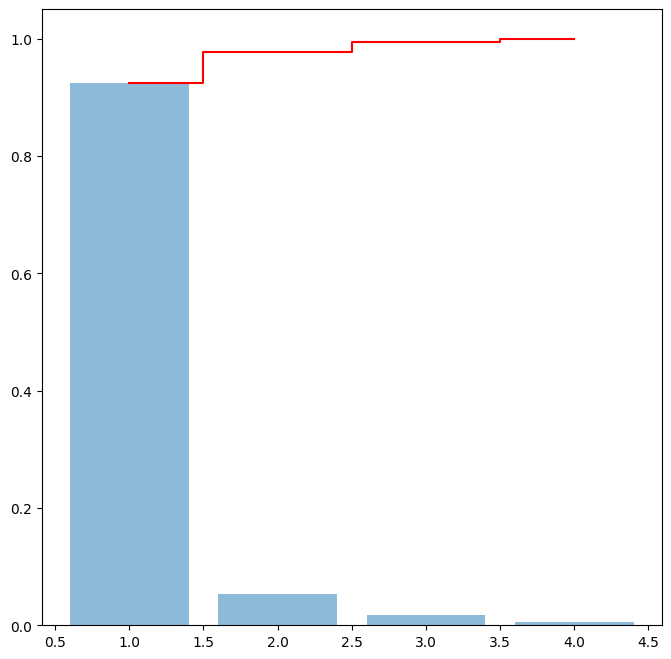

In [137]:
plt.figure(figsize = (8, 8))
plt.bar(
    range(1, len(explained_var_ratio)+1), explained_var_ratio,
    alpha = 0.5
    )
plt.step(
    range(1, len(cum_var_ratio) + 1), cum_var_ratio,
    color = 'red', where = 'mid'
)
plt.show()

- 막대 -> 각 주성분이 설명하는 분산의 비율
- 선 -> 누적 분산의 비율
- 일반적으로 누적 분산의 비율이 90% ~ 95% 이상이 되는 지점까지의 주성분만 선택하는 경우가 다수 -> 차원 축소 근거
- 이 그래프를 보고 iris 데이터에서는 보통 2개의 주성분 만으로 데이터의 분산의 대부분인 95%을 설명 가능하다

In [141]:
# 독립/종속
x = iris.drop('target', axis=1).values
y = iris['target']

# train, test 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# KFold를 사용하여 폴드화
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline 생성 -> Scaler, PCA, SCV
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('svc', SVC(random_state=42, probability=True))
    ]
)

# 최적의 파라미터를 찾기 위한 조합
params = {
    "pca__n_components" : [None, 2, 3],
    "svc__C" : [0.1, 1, 10],
    "svc__gamma" : ['scale', 'auto'],
    "svc__kernel" : ['linear', 'rbf']
}

# GridSearchCV 사용
grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring='accuracy',
    cv = cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# grid에 fit() 함수를 사용
grid.fit(X_train, Y_train)

print('Best estimator : ', grid.best_estimator_)
print('Best parameter : ', grid.best_params_)
print(classification_report(Y_test, grid.predict(X_test)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best estimator :  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(random_state=42)),
                ('svc',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=42))])
Best parameter :  {'pca__n_components': None, 'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [144]:
pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)[
    ['mean_fit_time', 'params', 'mean_test_score']
]

,mean_fit_time,params,mean_test_score
0,0.005783,"{'pca__n_components': None, 'svc__C': 0.1, 'sv...",0.975000
24,0.004604,"{'pca__n_components': 3, 'svc__C': 0.1, 'svc__...",0.975000
2,0.001520,"{'pca__n_components': None, 'svc__C': 0.1, 'sv...",0.975000
4,0.001892,"{'pca__n_components': None, 'svc__C': 1, 'svc_...",0.975000
6,0.002026,"{'pca__n_components': None, 'svc__C': 1, 'svc_...",0.975000
26,0.001537,"{'pca__n_components': 3, 'svc__C': 0.1, 'svc__...",0.975000
33,0.005226,"{'pca__n_components': 3, 'svc__C': 10, 'svc__g...",0.966667
31,0.002562,"{'pca__n_components': 3, 'svc__C': 1, 'svc__ga...",0.966667
30,0.001561,"{'pca__n_components': 3, 'svc__C': 1, 'svc__ga...",0.966667
29,0.002804,"{'pca__n_components': 3, 'svc__C': 1, 'svc__ga...",0.966667
